In [1]:
#Expand notebook to take full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#Jupyter magic to notify when a cell finishes execution with %%notify command -- does not work with Jupyterlab
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

<IPython.core.display.Javascript object>

In [2]:
import gc

def memReport():
    for obj in gc.get_objects():
        if torch.is_tensor(obj):
            print(type(obj), obj.size())

In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn.modules import Module
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import IPython.display as ipd
import imageio
import copy
from tensorboardX import SummaryWriter
import pickle 

writeTensorboard = True
if(writeTensorboard):
    writer = SummaryWriter('tensorboard/run1/')

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
sns.set(color_codes=True)
sns.set_style("whitegrid")

model_dir = "./models/"
import models
from plot_utils import show_sws_weights, show_weights, print_dims, prune_plot, draw_sws_graphs, joint_plot
from model_utils import test_accuracy, train_epoch, retrain_sws_epoch, model_prune, get_weight_penalty
from helpers import trueAfterN, logsumexp
from sws_utils import GaussianMixturePrior, special_flatten, KL, compute_responsibilies, merger, sws_prune

#Data
train_dataset = dsets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.MNIST(root='./data', train=False , transform=transforms.ToTensor(), download=True)
#train_dataset.train_labels = train_dataset.train_labels.float()
#test_dataset.test_labels = test_dataset.test_labels.float()

model_name = "SWSModel"

In [4]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
train_data_full = Variable(train_dataset.train_data.float()/255.0).cuda()
test_data_full = Variable(test_dataset.test_data.float()/255.0).cuda()
train_labels_full = Variable(train_dataset.train_labels).cuda()
test_labels_full = Variable(test_dataset.test_labels).cuda()

#arguments
#model_name = 'LeNet_300_100'
training_epochs=100
#retraining_epochs=50
#temp_list = [1, 5, 10, 15, 20, 25, 30]

### 2. Re-train Model with GMM Constraints

In [22]:
def get_layer_precision(model_retrain, gmp, model_orig, data, labels):
    model_acc = copy.deepcopy(model_orig)
    org_acc = (test_accuracy(data, labels, model))

    weight_loader = copy.deepcopy(model_orig.state_dict())
    for layer in model_retrain.state_dict():
        weight_loader[layer] = model_retrain.state_dict()[layer]
    model_acc.load_state_dict(weight_loader)
    retrain_acc = (test_accuracy(data, labels, model_acc))
    model_acc.load_state_dict(model_orig.state_dict())

    model_prune = copy.deepcopy(model_retrain)
    model_prune.load_state_dict(sws_prune(model_prune, gmp))

    weight_loader = copy.deepcopy(model_orig.state_dict())
    for layer in model_prune.state_dict():
        weight_loader[layer] = model_prune.state_dict()[layer]
    model_acc.load_state_dict(weight_loader)
    prune_acc = (test_accuracy(data, labels, model_acc))
    model_acc.load_state_dict(model_orig.state_dict())
    
    print ("Original: {:.2f}% - Retrain: {:.2f}% - Prune: {:.2f}%".format(org_acc[0], retrain_acc[0], prune_acc[0]))
    
def retrain_layer(model_retrain, model_orig, data_loader, test_data_full, test_labels_full, alpha, beta, tau):
    ipd.display(ipd.Markdown("**Model: {}**".format(model_retrain.name)))
    
    weight_loader = model_retrain.state_dict()
    for layer in model_retrain.state_dict():
        weight_loader[layer] = model_orig.state_dict()[layer]
    model_retrain.load_state_dict(weight_loader)

    gmp = GaussianMixturePrior(16, [x for x in model_retrain.parameters()], 0.99, ab = (alpha, beta))

    sws_param1 = [gmp.means]
    sws_param2 = [gmp.gammas, gmp.rhos]

    print ("Model Name: {} Epochs: {}".format(model_retrain.name, training_epochs))
    print_dims(model_retrain)
    criterion = nn.MSELoss()
    optimizer_kd = torch.optim.SGD(model_retrain.parameters(), lr=1e-3, weight_decay = 0)
    optimizer_gmp1 = torch.optim.SGD(sws_param1, lr=1e-4)
    optimizer_gmp2 = torch.optim.SGD(sws_param2, lr=3e-3)
    
    for epoch in range(40):
        model_retrain, loss = retrain_sws_epoch(model_retrain, gmp, optimizer_kd, optimizer_gmp1, optimizer_gmp2, criterion, data_loader, tau)
        #if(writeTensorboard):
        #    for name, param in model_retrain.named_parameters():
        #       writer.add_histogram(graph_title + "/" + name, param.clone().cpu().data.numpy(), epoch+1, bins='doane')

        if (trueAfterN(epoch, 5)):
            #gmp.print_batch = True
            print('Epoch: {}. Loss: {:.2f}'.format(epoch+1, float(loss.data)))
            get_layer_precision(model_retrain, gmp, model_orig, test_data_full, test_labels_full)
            show_sws_weights(model = model_retrain, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()), epoch = epoch)
    exp_name = "{}_a{}_b{}_t{}".format(model_retrain.name, alpha, beta, tau)
    torch.save(model_retrain, model_dir + 'mnist_layer_{}.m'.format(exp_name))
    with open(model_dir + 'mnist_retrain_{}_gmp.p'.format(exp_name),'wb') as f:
        pickle.dump(gmp, f)
            
    return model_retrain, gmp

In [5]:
#Load Targets
model_file = 'mnist_{}_{}'.format(model_name, 100)
model = torch.load("{}{}.m".format(model_dir, model_file)).cuda()
model_acc = torch.load("{}{}.m".format(model_dir, model_file)).cuda()
#targets = model.kd_layer_targets(train_data_full)
#for layer in targets:
#    torch.save(targets[layer], "{}{}/{}.m".format(model_dir, model_file, layer))

In [6]:
T = 3

In [7]:
target_layers = list(set([x.split(".")[0] for x in model.state_dict().keys()]))
kd_targets = {}
for layer in target_layers:
    kd_targets[layer+".out"] = torch.load("{}{}/{}.out.m".format(model_dir, model_file, layer))
    
    if T != 0 and "fc" in layer:
        kd_targets[layer+".out"] = nn.Softmax(dim=1)(kd_targets[layer+".out"]/T)
    
    if layer!="fc2":
        kd_targets[layer+".act"] = nn.ReLU()(kd_targets[layer+".out"])

In [8]:
kd_targets.keys()

dict_keys(['conv1.out', 'fc2.out', 'fc1.out', 'conv2.out', 'fc1.act', 'conv1.act', 'conv2.act'])

In [81]:
kd_targets["fc1.act"]

Variable containing:
  0.0000   0.0000   0.0000  ...    0.0000  19.1929   0.0000
  0.0000   0.0000  16.6072  ...    0.0000   6.7586   0.0000
  0.0000   0.0000   4.0171  ...    0.0000   0.0000   0.0000
           ...               ⋱              ...            
  0.0000   0.0000   0.0000  ...    0.0000  25.8088   0.0000
  0.0000   0.0000   0.0000  ...    0.0000   0.0000   0.0000
  0.0000   0.0000   0.0000  ...    0.0000   4.9094   0.0000
[torch.cuda.FloatTensor of size 60000x500 (GPU 0)]

In [82]:
nn.ReLU()(kd_targets["fc1.out"])

Variable containing:
  0.0000   0.0000   0.0000  ...    0.0000  19.1929   0.0000
  0.0000   0.0000  16.6072  ...    0.0000   6.7586   0.0000
  0.0000   0.0000   4.0171  ...    0.0000   0.0000   0.0000
           ...               ⋱              ...            
  0.0000   0.0000   0.0000  ...    0.0000  25.8088   0.0000
  0.0000   0.0000   0.0000  ...    0.0000   0.0000   0.0000
  0.0000   0.0000   0.0000  ...    0.0000   4.9094   0.0000
[torch.cuda.FloatTensor of size 60000x500 (GPU 0)]

In [57]:
kd_targets["fc2.out"][0:3]

Variable containing:

Columns 0 to 7 
-135.3484  -34.2556 -129.6953   79.6020 -235.6991  121.1703 -137.5909  -89.0560
 166.8393  -37.3335    5.7377  -74.2520 -144.4291 -163.4962  -58.6244  -42.4433
-171.0004  -82.5898 -124.2936 -118.1381  123.7778  -73.3439 -117.6545  -73.9540

Columns 8 to 9 
 -81.9374  -38.9243
-129.9014  -53.7331
 -13.0700  -32.8715
[torch.cuda.FloatTensor of size 3x10 (GPU 0)]

In [61]:
nn.ReLU()(nn.Softmax(dim=1)(kd_targets["fc2.out"][0:3]/T))

Variable containing:
 0.0000  0.0000  0.0000  0.0000  0.0000  1.0000  0.0000  0.0000  0.0000  0.0000
 1.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000
[torch.cuda.FloatTensor of size 3x10 (GPU 0)]

In [56]:
nn.softmax(kd_targets["fc1.out"]/5)*400

AttributeError: module 'torch.nn' has no attribute 'softmax'

In [25]:
l1_dataset = torch.utils.data.TensorDataset(train_data_full.data, kd_targets['conv1.out'].data)#.data turns variable -> tensor
l1_loader = torch.utils.data.DataLoader(dataset=l1_dataset, batch_size=batch_size, shuffle=True)

l2_dataset = torch.utils.data.TensorDataset(kd_targets['conv1.act'].data, kd_targets['conv2.out'].data)#.data turns variable -> tensor
l2_loader = torch.utils.data.DataLoader(dataset=l2_dataset, batch_size=batch_size, shuffle=True)

l3_dataset = torch.utils.data.TensorDataset(kd_targets['conv2.act'].data, kd_targets['fc1.out'].data)#.data turns variable -> tensor
l3_loader = torch.utils.data.DataLoader(dataset=l3_dataset, batch_size=batch_size, shuffle=True)

l4_dataset = torch.utils.data.TensorDataset(kd_targets['fc1.act'].data, kd_targets['fc2.out'].data)#.data turns variable -> tensor
l4_loader = torch.utils.data.DataLoader(dataset=l4_dataset, batch_size=batch_size, shuffle=True)                                            

**Model: SWSModelFC2**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 2500.0 Variance: 25.0
Model Name: SWSModelFC2 Epochs: 100
10x500 + 10
Layer Loss: 3327.047
Layer Loss: 5.556
0-neglogprop Loss: -13828.171
Remaining-neglogprop Loss: -10373166.000
Epoch: 5. Loss: 0.06
Original: 98.89% - Retrain: 98.90% - Prune: 98.83%


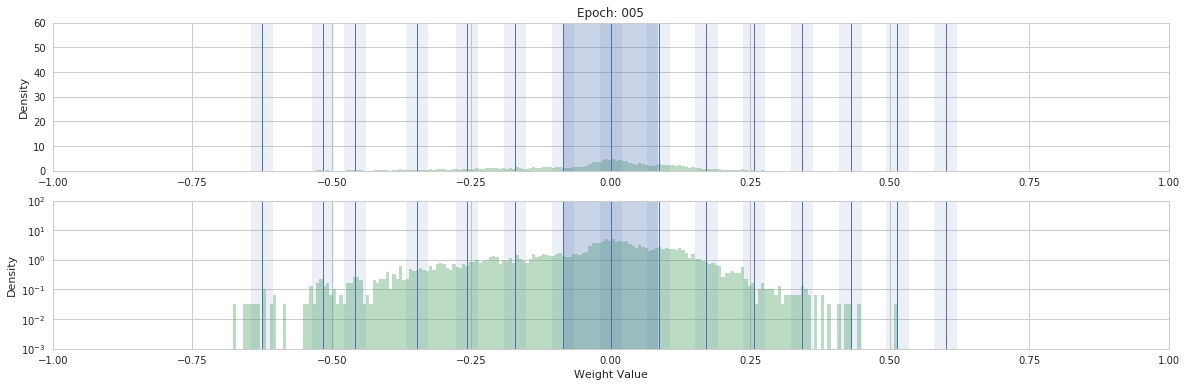

Epoch: 10. Loss: 0.10
Original: 98.89% - Retrain: 98.90% - Prune: 98.83%


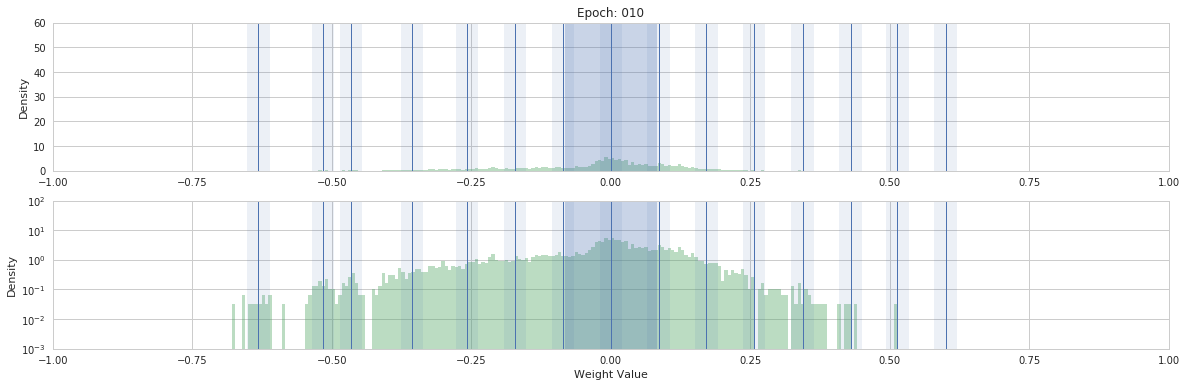

Epoch: 15. Loss: 0.10
Original: 98.89% - Retrain: 98.90% - Prune: 98.86%


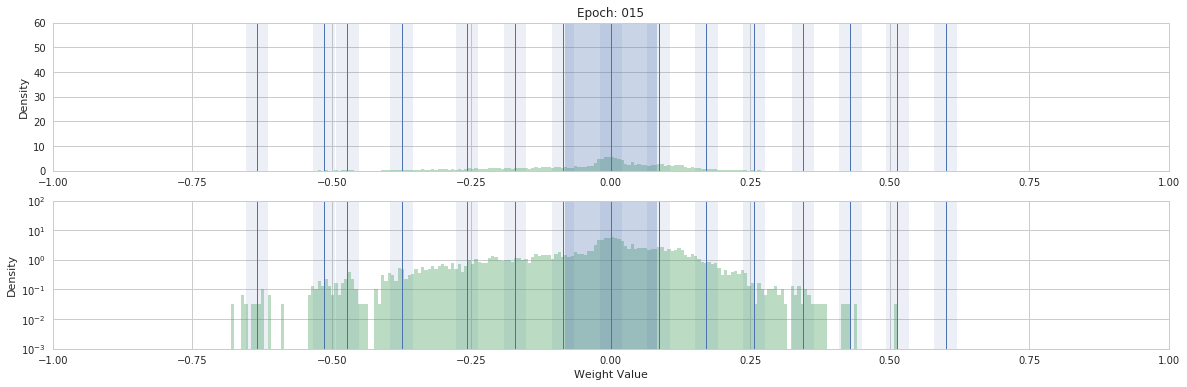

Epoch: 20. Loss: 0.12
Original: 98.89% - Retrain: 98.90% - Prune: 98.83%


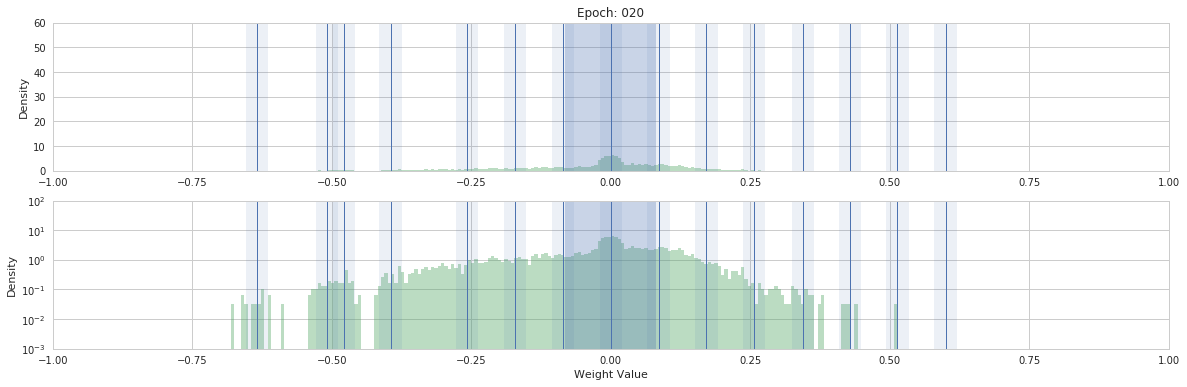

Epoch: 25. Loss: 0.14
Original: 98.89% - Retrain: 98.90% - Prune: 98.85%


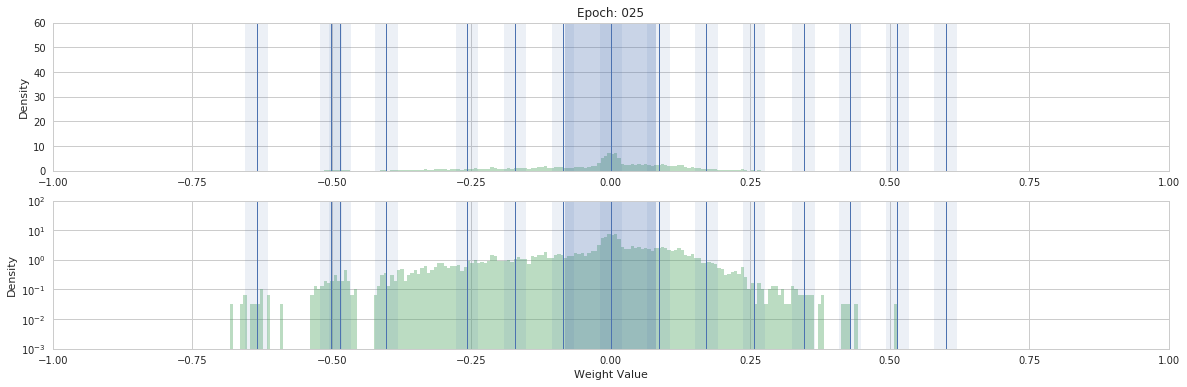

Epoch: 30. Loss: 0.13
Original: 98.89% - Retrain: 98.90% - Prune: 98.85%


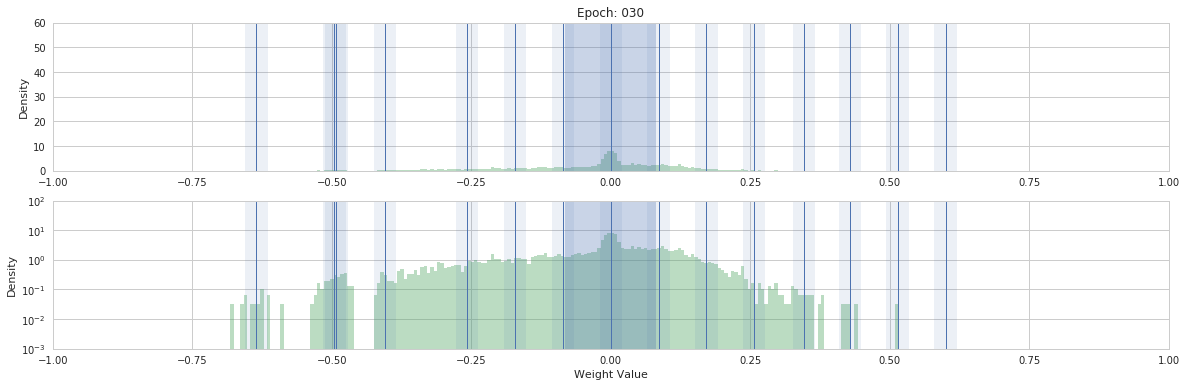

Epoch: 35. Loss: 0.14
Original: 98.89% - Retrain: 98.90% - Prune: 98.85%


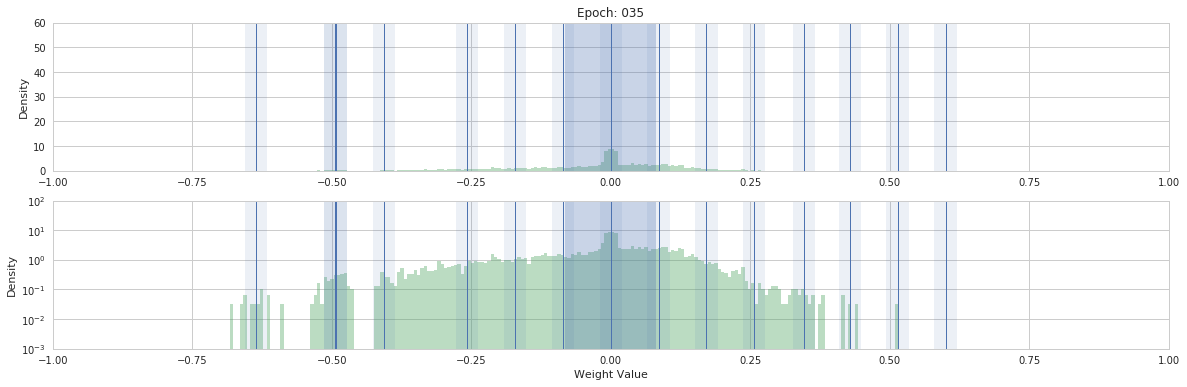

Epoch: 40. Loss: 0.15
Original: 98.89% - Retrain: 98.90% - Prune: 98.85%


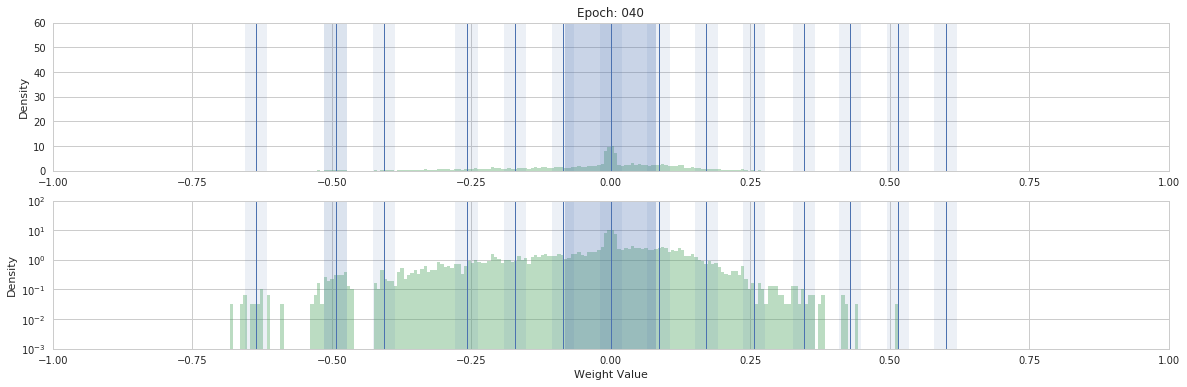

In [26]:
fc2, fc2_gmp = retrain_layer(models.SWSModelFC2().cuda(), model, l4_loader, test_data_full, test_labels_full, 2.5e5, 100, 5e-4)

**Model: SWSModelConv1**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 2500.0 Variance: 25.0
Model Name: SWSModelConv1 Epochs: 100
25x1x5x5 + 25
Layer Loss: 627.421
Layer Loss: 15.527
0-neglogprop Loss: -13828.171
Remaining-neglogprop Loss: -10373166.000
Epoch: 5. Loss: 0.02
Original: 98.89% - Retrain: 98.83% - Prune: 98.78%


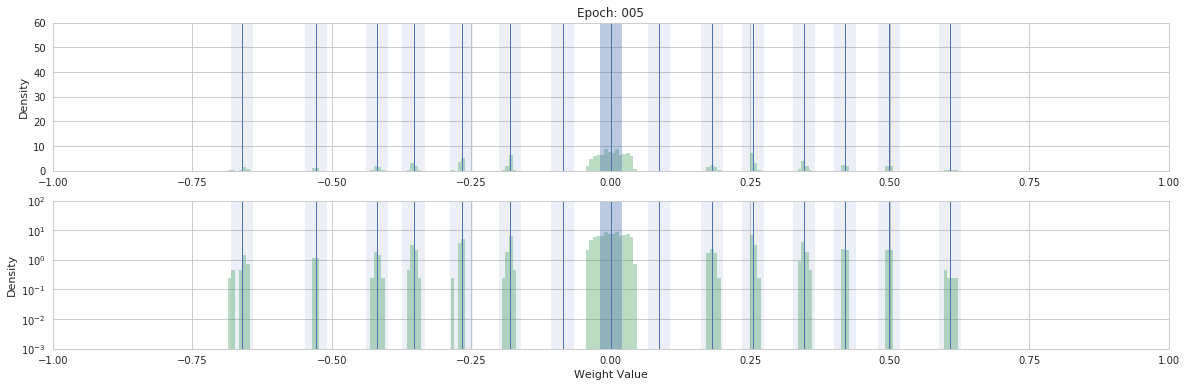

Epoch: 10. Loss: 0.03
Original: 98.89% - Retrain: 98.78% - Prune: 98.79%


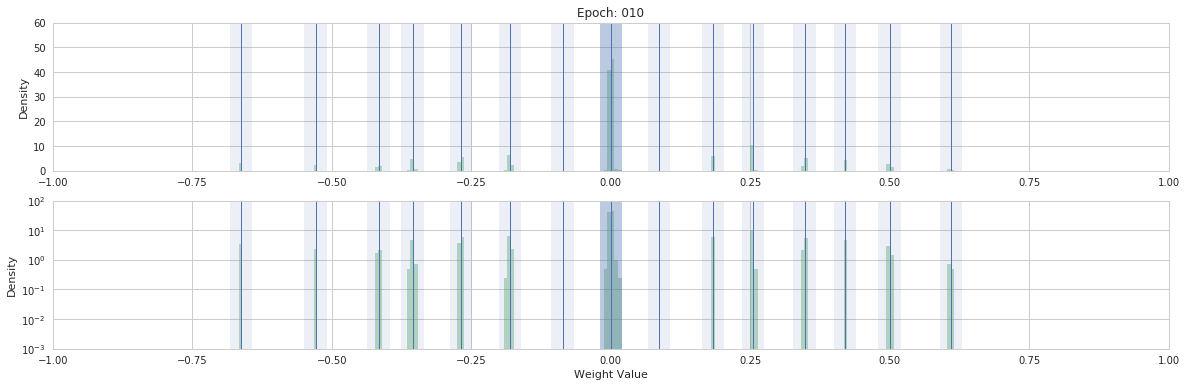

Epoch: 15. Loss: 0.03
Original: 98.89% - Retrain: 98.78% - Prune: 98.79%


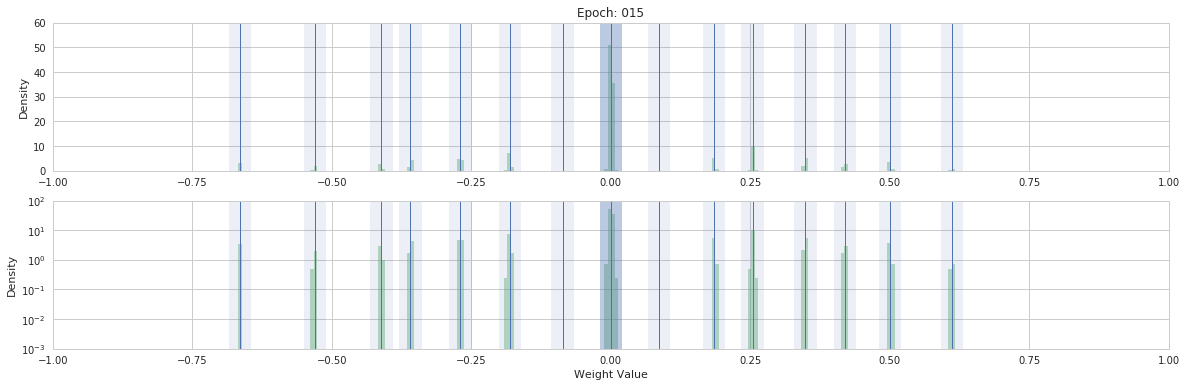

Epoch: 20. Loss: 0.03
Original: 98.89% - Retrain: 98.80% - Prune: 98.79%


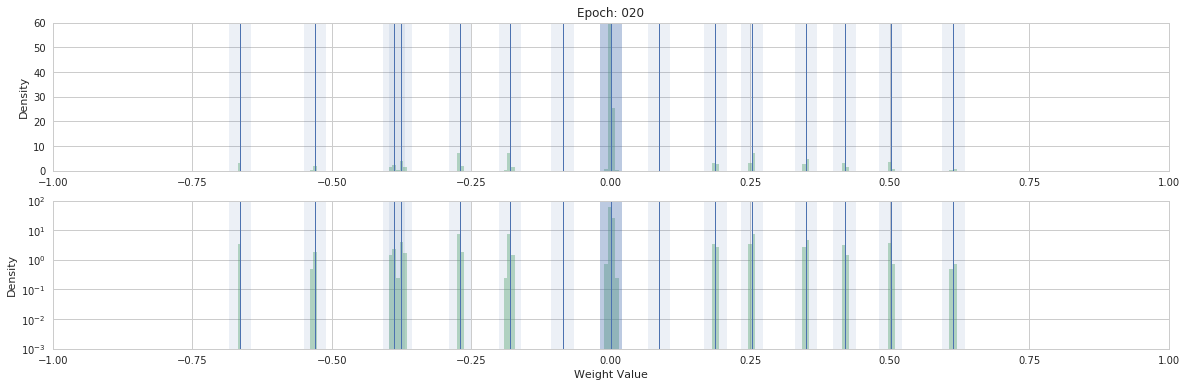

Epoch: 25. Loss: 0.03
Original: 98.89% - Retrain: 98.80% - Prune: 98.78%


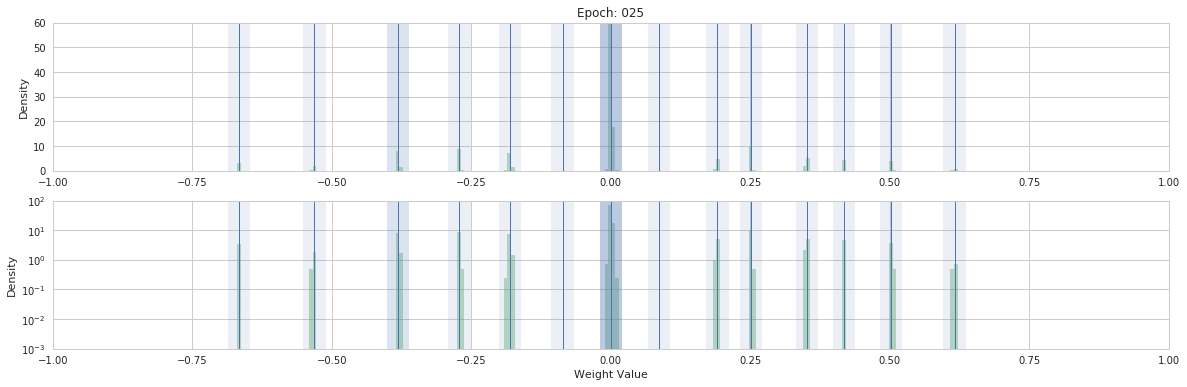

Epoch: 30. Loss: 0.02
Original: 98.89% - Retrain: 98.81% - Prune: 98.78%


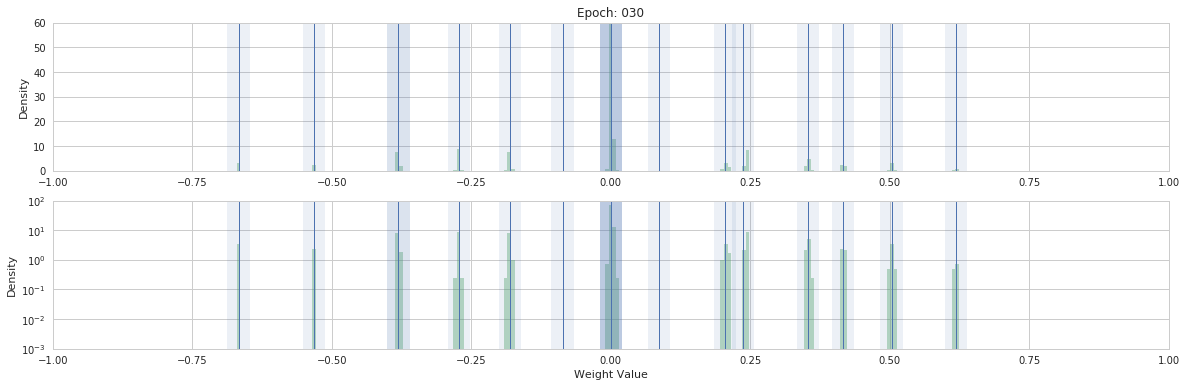

Epoch: 35. Loss: 0.03
Original: 98.89% - Retrain: 98.80% - Prune: 98.79%


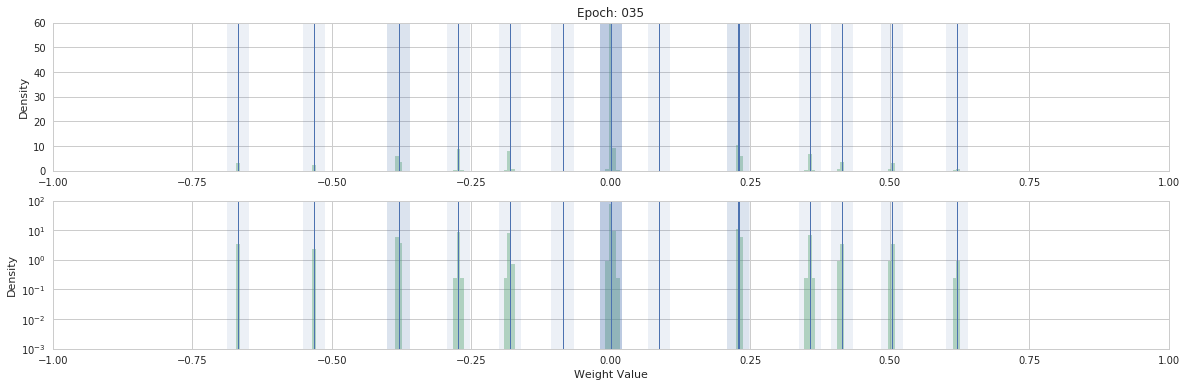

Epoch: 40. Loss: 0.03
Original: 98.89% - Retrain: 98.79% - Prune: 98.78%


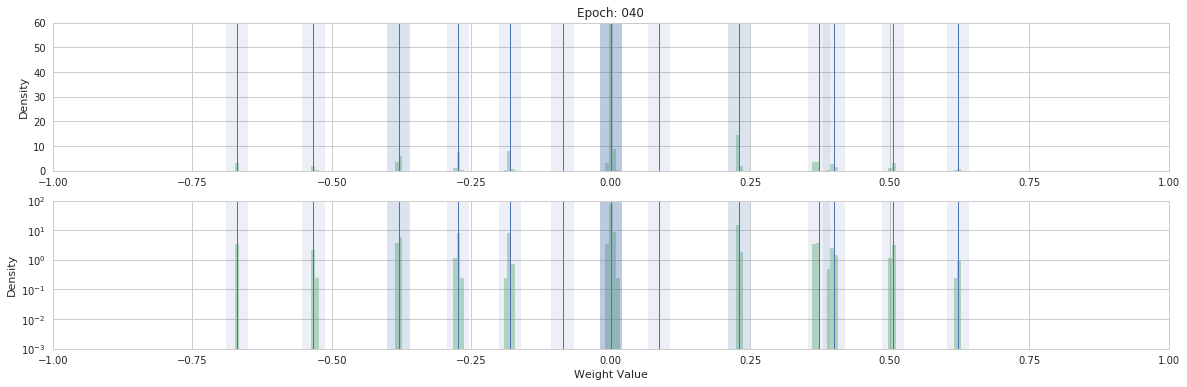

**Model: SWSModelConv2**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 2500.0 Variance: 25.0
Model Name: SWSModelConv2 Epochs: 100
50x25x3x3 + 50
Layer Loss: 8048.500
Layer Loss: 24.987
0-neglogprop Loss: -13828.171
Remaining-neglogprop Loss: -10373166.000
Epoch: 5. Loss: 0.04
Original: 98.89% - Retrain: 98.90% - Prune: 98.88%


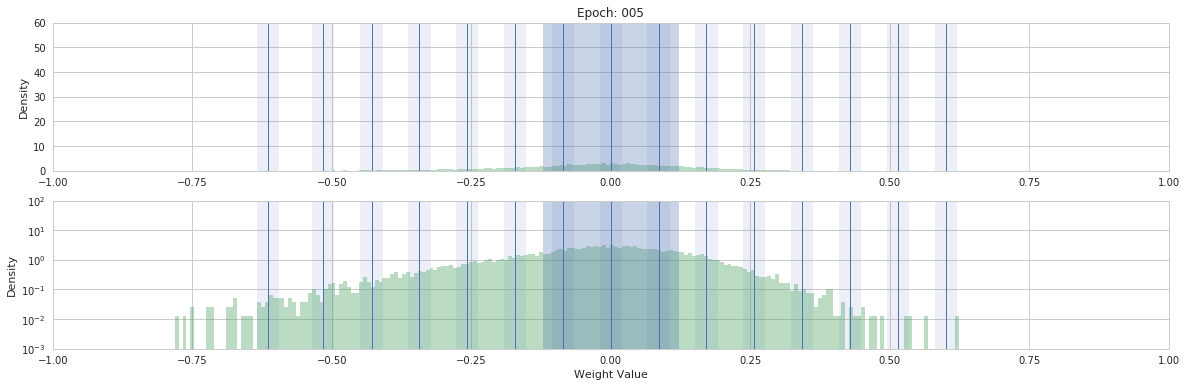

Epoch: 10. Loss: 0.14
Original: 98.89% - Retrain: 98.87% - Prune: 98.90%


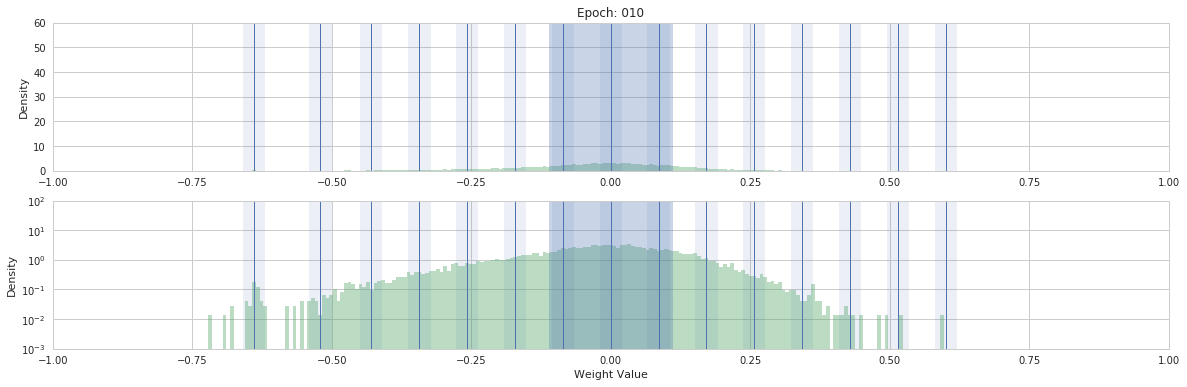

Epoch: 15. Loss: 0.27
Original: 98.89% - Retrain: 98.88% - Prune: 98.97%


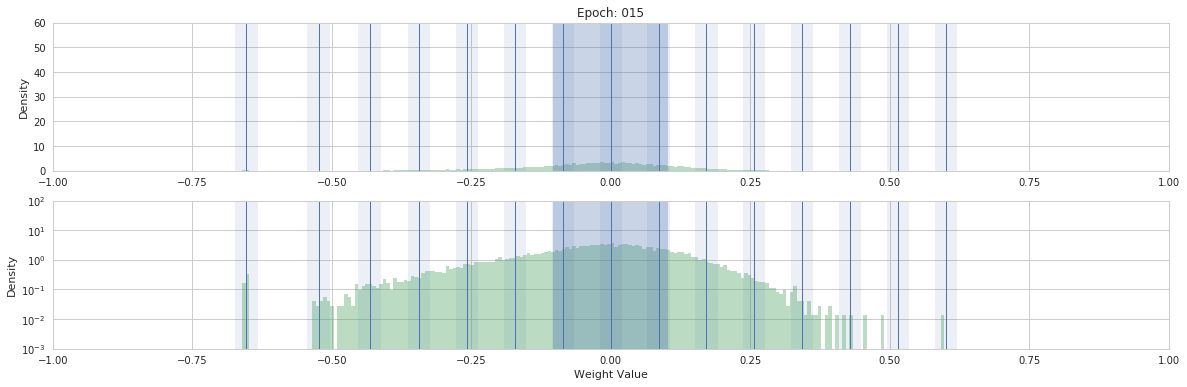

Epoch: 20. Loss: 0.43
Original: 98.89% - Retrain: 98.87% - Prune: 98.89%


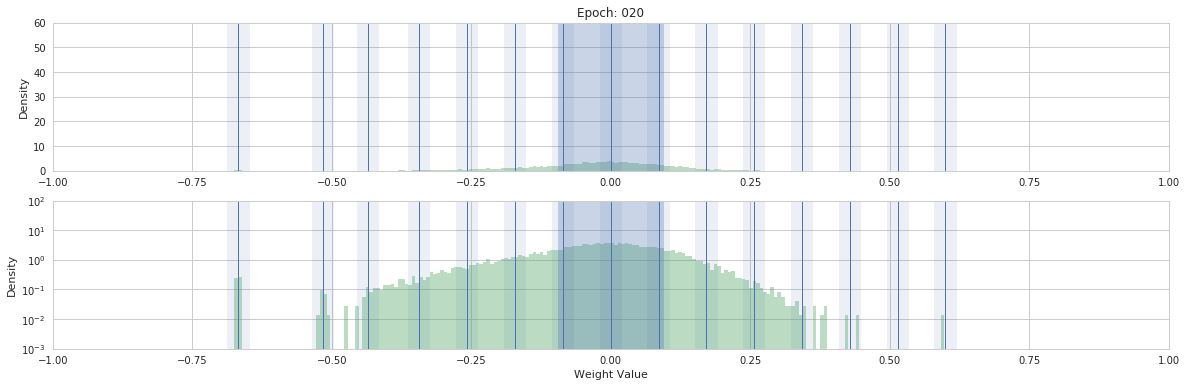

Epoch: 25. Loss: 0.59
Original: 98.89% - Retrain: 98.82% - Prune: 98.82%


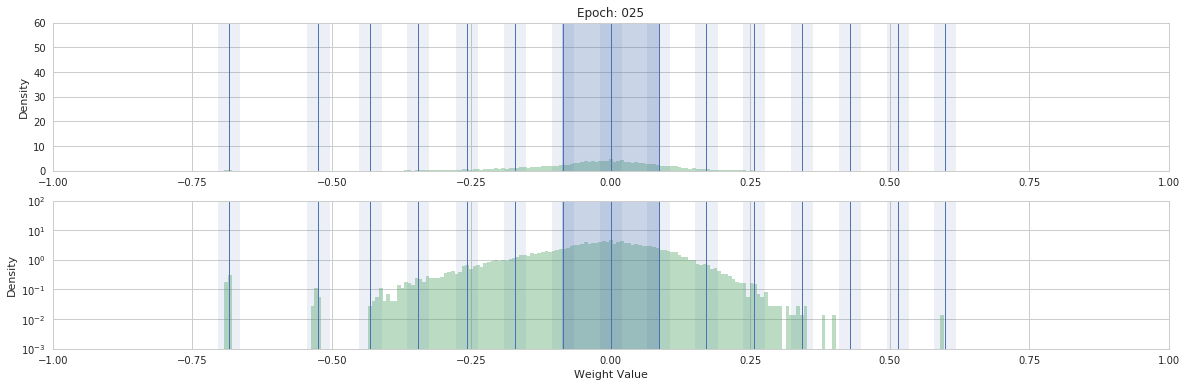

Epoch: 30. Loss: 0.85
Original: 98.89% - Retrain: 98.70% - Prune: 98.72%


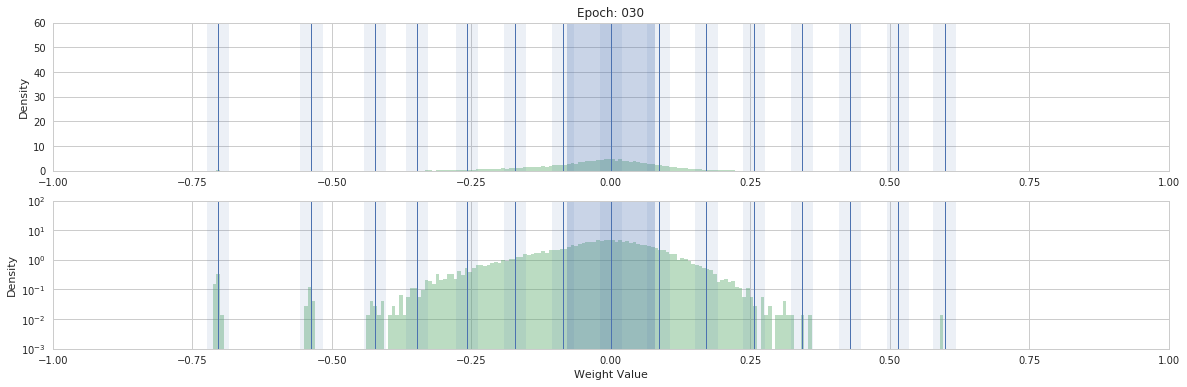

Epoch: 35. Loss: 1.20
Original: 98.89% - Retrain: 98.60% - Prune: 98.54%


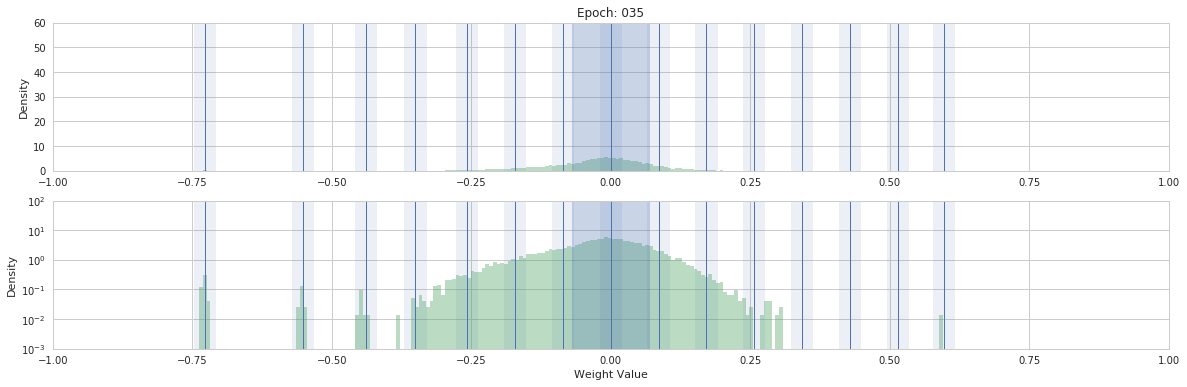

Epoch: 40. Loss: 1.58
Original: 98.89% - Retrain: 98.47% - Prune: 98.32%


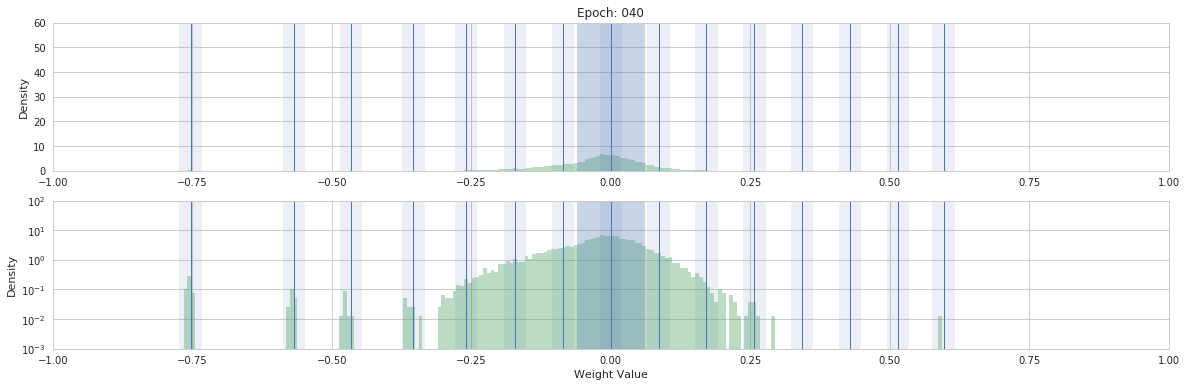

**Model: SWSModelFC1**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 2500.0 Variance: 25.0
Model Name: SWSModelFC1 Epochs: 100
500x1250 + 500
Layer Loss: 364856.500
Layer Loss: 247.245
0-neglogprop Loss: -13828.171
Remaining-neglogprop Loss: -10373166.000
Epoch: 5. Loss: 0.94
Original: 98.89% - Retrain: 98.84% - Prune: 98.92%


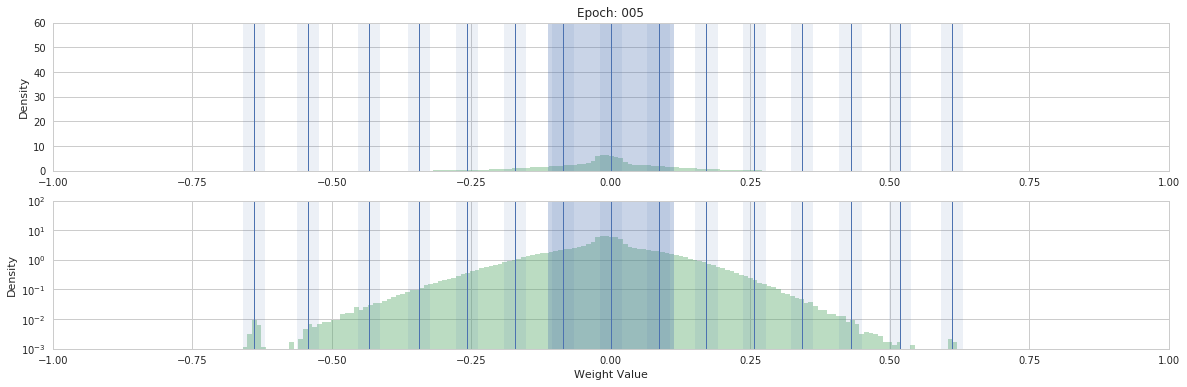

Epoch: 10. Loss: 2.93
Original: 98.89% - Retrain: 98.81% - Prune: 98.86%


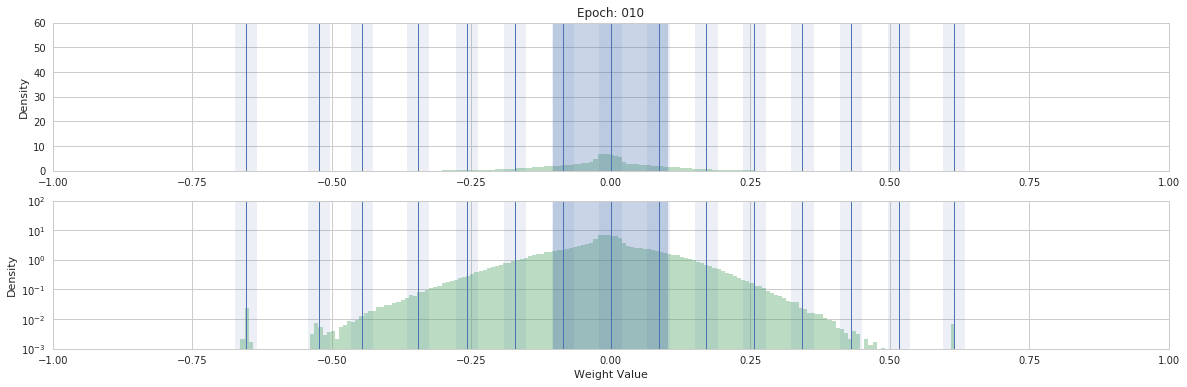

Epoch: 15. Loss: 5.65
Original: 98.89% - Retrain: 98.74% - Prune: 98.83%


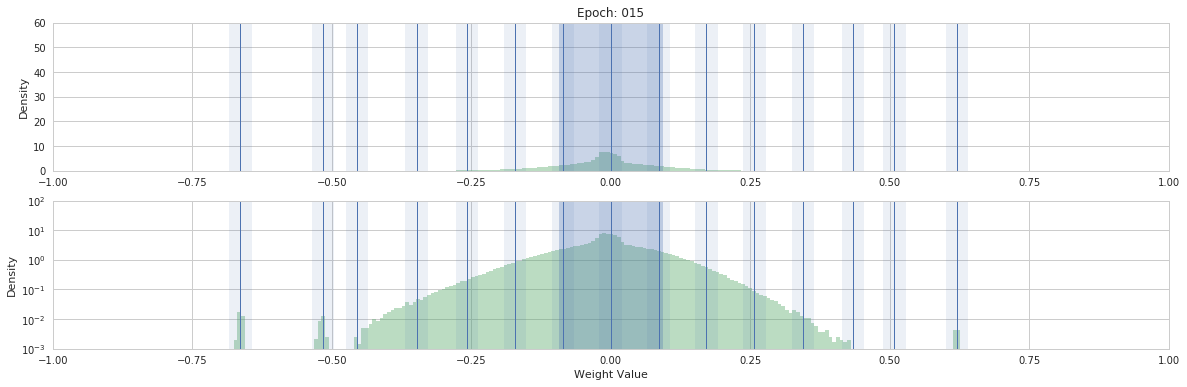

Epoch: 20. Loss: 8.82
Original: 98.89% - Retrain: 98.65% - Prune: 98.68%


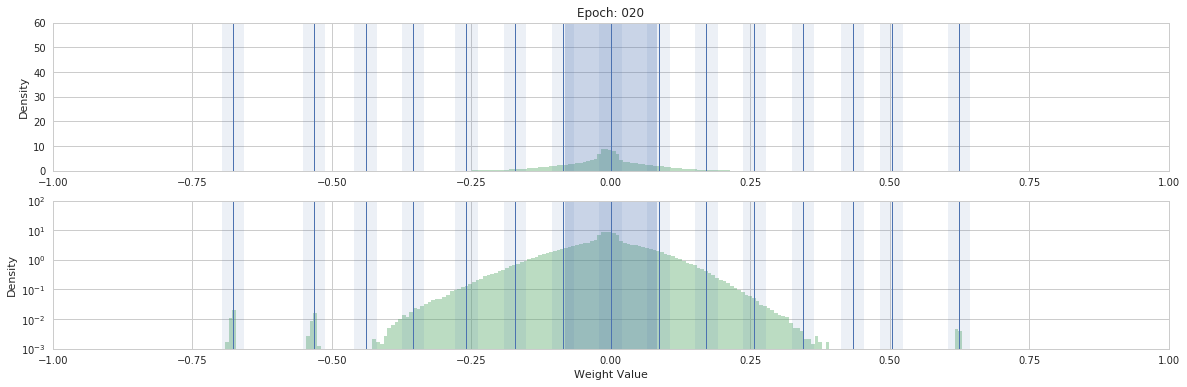

Epoch: 25. Loss: 14.78
Original: 98.89% - Retrain: 98.43% - Prune: 98.54%


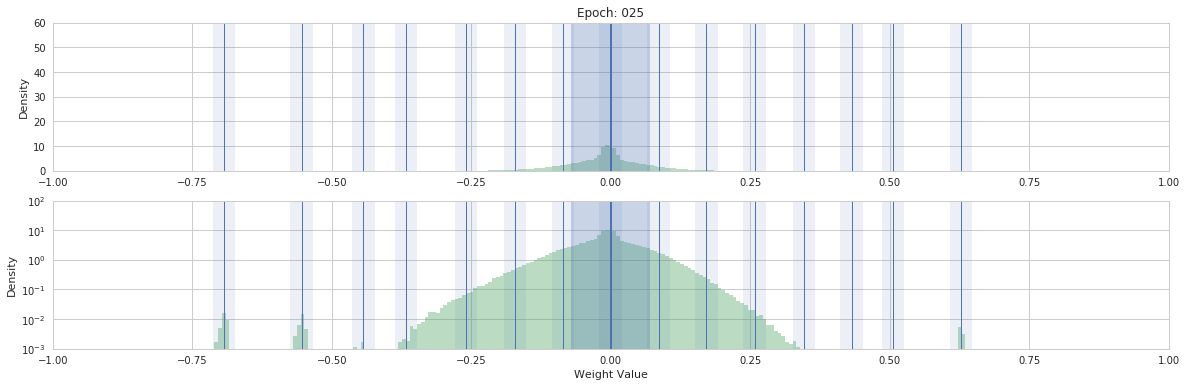

Epoch: 30. Loss: 26.58
Original: 98.89% - Retrain: 98.02% - Prune: 98.08%


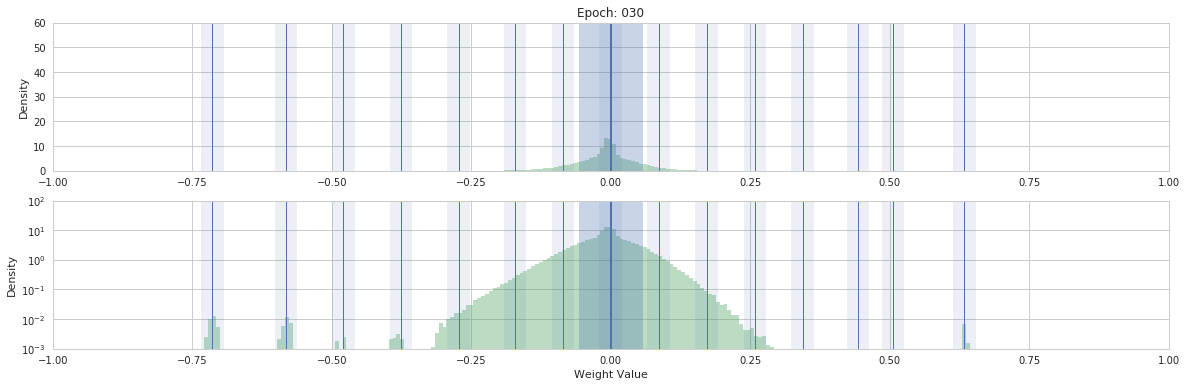

Epoch: 35. Loss: 42.35
Original: 98.89% - Retrain: 96.98% - Prune: 96.54%


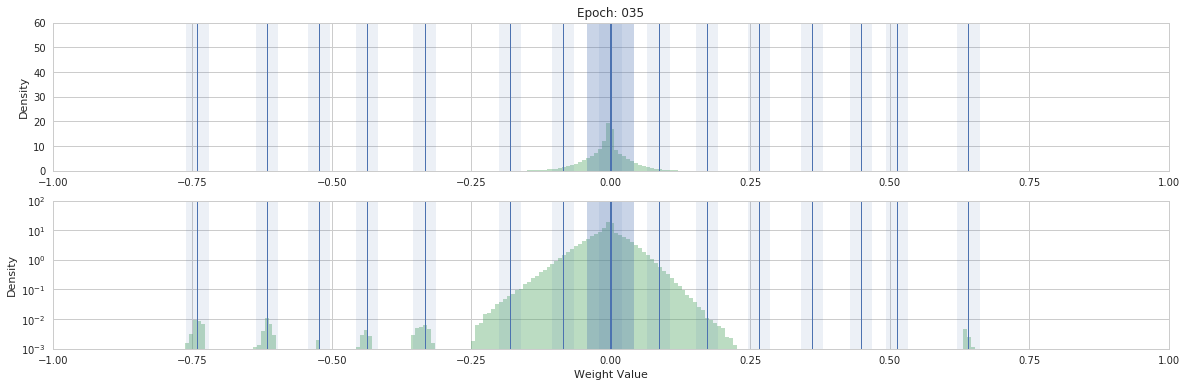

Epoch: 40. Loss: 127.03
Original: 98.89% - Retrain: 85.43% - Prune: 51.47%


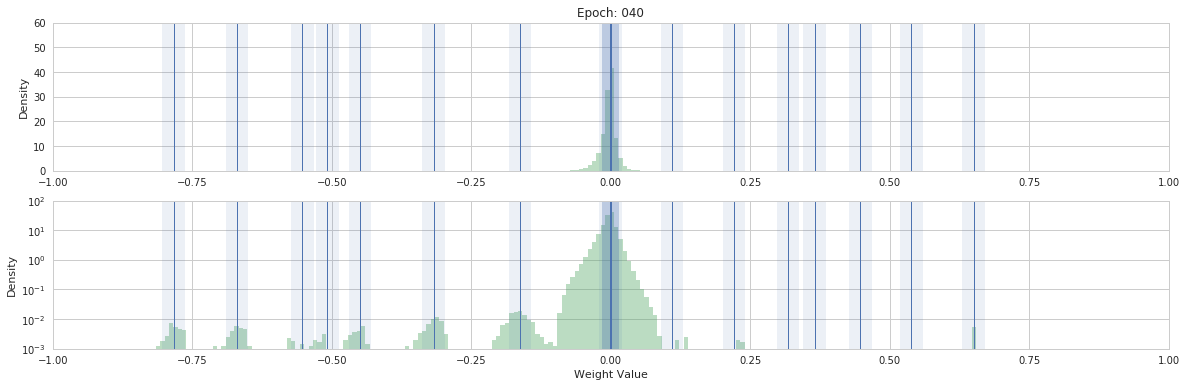

**Model: SWSModelFC2**

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 2500.0 Variance: 25.0
Model Name: SWSModelFC2 Epochs: 100
10x500 + 10
Layer Loss: 3327.047
Layer Loss: 5.556
0-neglogprop Loss: -13828.171
Remaining-neglogprop Loss: -10373166.000
Epoch: 5. Loss: 0.06
Original: 98.89% - Retrain: 98.90% - Prune: 98.82%


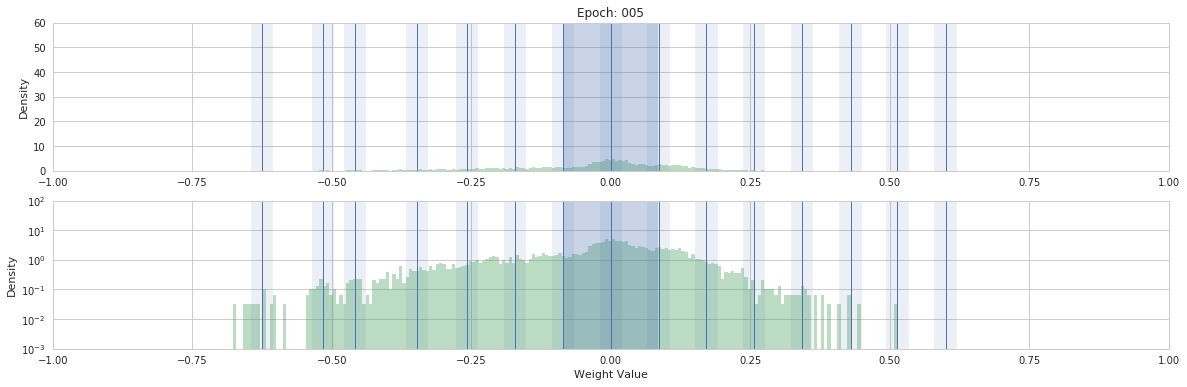

Epoch: 10. Loss: 0.09
Original: 98.89% - Retrain: 98.90% - Prune: 98.83%


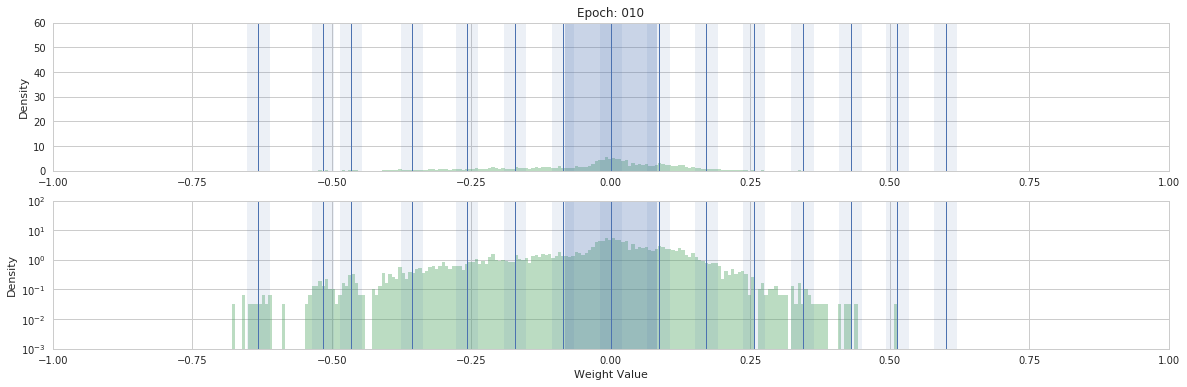

Epoch: 15. Loss: 0.12
Original: 98.89% - Retrain: 98.90% - Prune: 98.85%


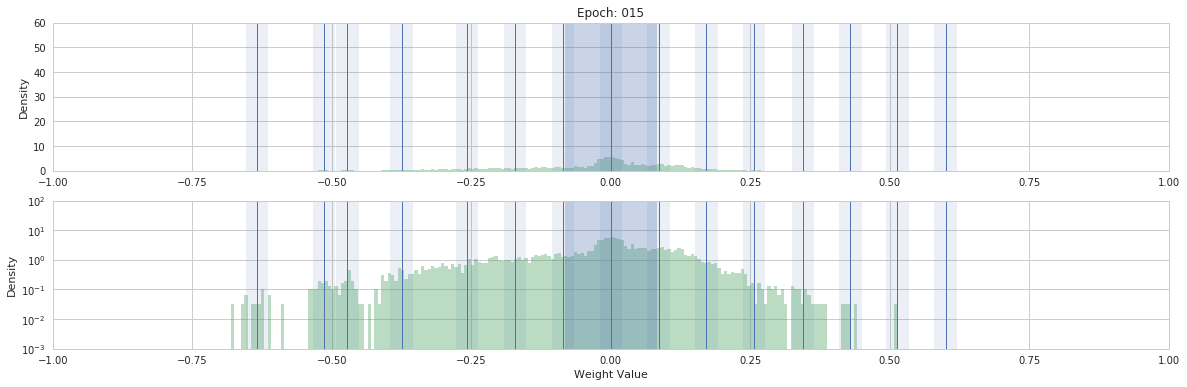

Epoch: 20. Loss: 0.12
Original: 98.89% - Retrain: 98.90% - Prune: 98.84%


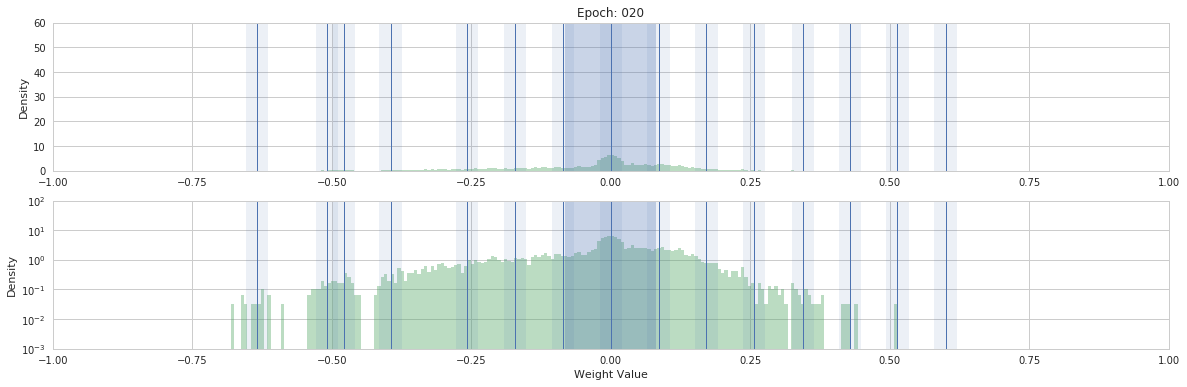

Epoch: 25. Loss: 0.13
Original: 98.89% - Retrain: 98.90% - Prune: 98.85%


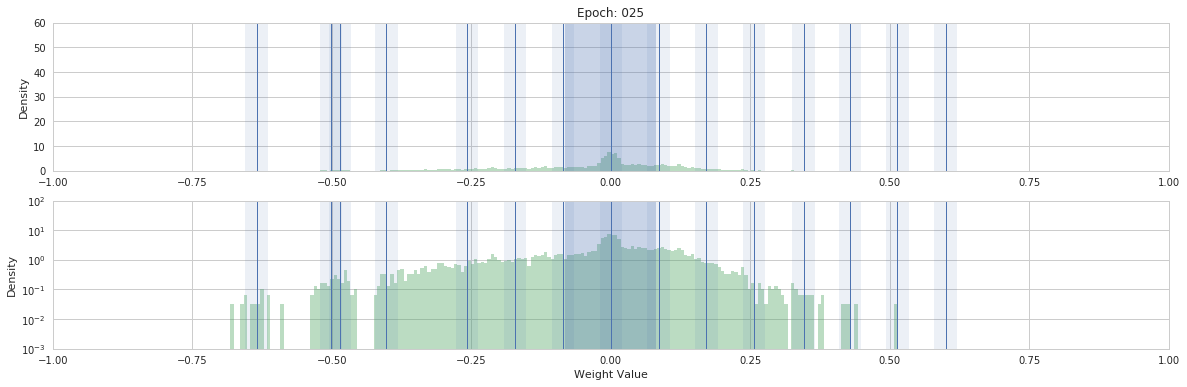

Epoch: 30. Loss: 0.12
Original: 98.89% - Retrain: 98.90% - Prune: 98.85%


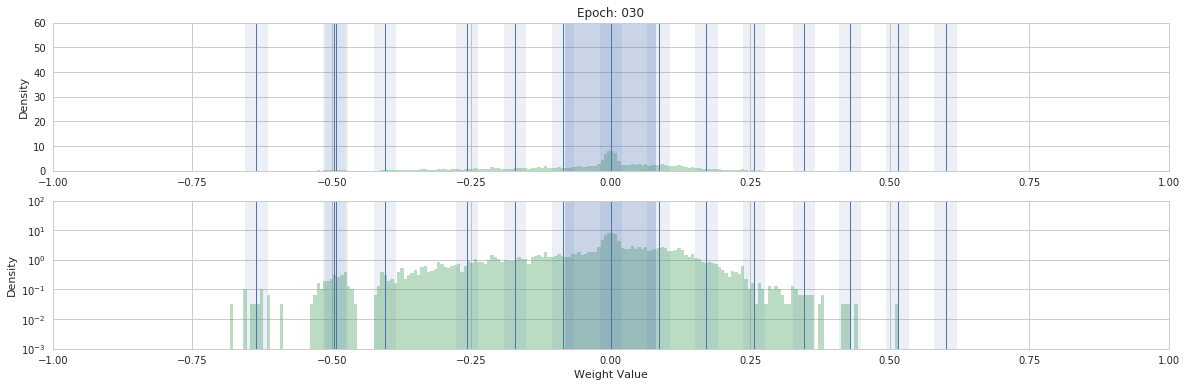

Epoch: 35. Loss: 0.13
Original: 98.89% - Retrain: 98.90% - Prune: 98.85%


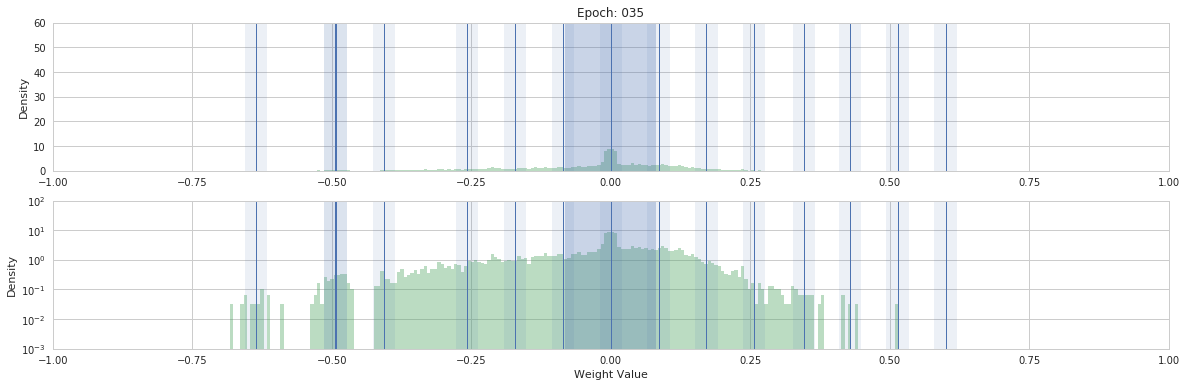

Epoch: 40. Loss: 0.13
Original: 98.89% - Retrain: 98.90% - Prune: 98.86%


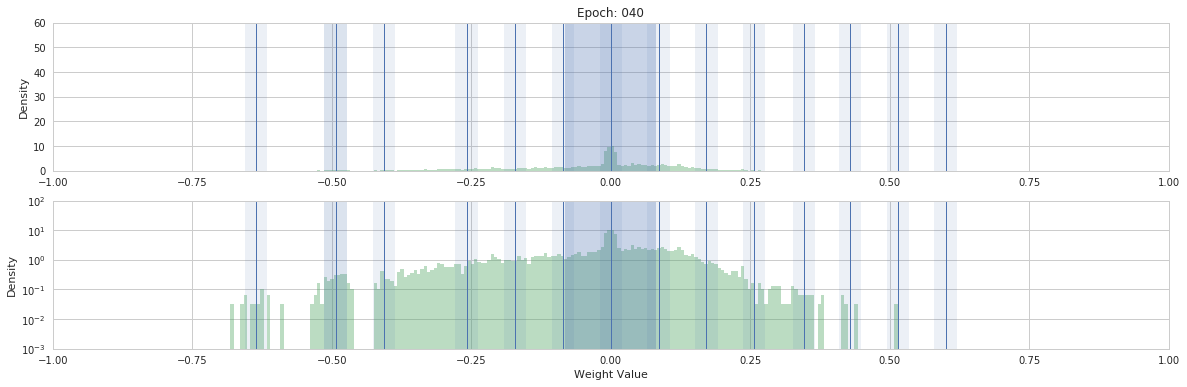

In [19]:
conv1, conv1_gmp = retrain_layer(models.SWSModelConv1().cuda(), model, l1_loader, test_data_full, test_labels_full, 2.5e5, 100, 5e-4)
conv2, conv2_gmp = retrain_layer(models.SWSModelConv2().cuda(), model, l2_loader, test_data_full, test_labels_full, 2.5e5, 100, 5e-4)
fc1, fc1_gmp = retrain_layer(models.SWSModelFC1().cuda(), model, l3_loader, test_data_full, test_labels_full, 2.5e5, 100, 5e-4)
fc2, fc2_gmp = retrain_layer(models.SWSModelFC2().cuda(), model, l4_loader, test_data_full, test_labels_full, 2.5e5, 100, 5e-4)

In [6]:
def sws_replace(model_orig, conv1, conv2, fc1, fc2):
    new_model = copy.deepcopy(model_orig)
    new_dict = new_model.state_dict()
    for layer in conv1:
        new_dict[layer] = conv1[layer]
    for layer in conv2:
        new_dict[layer] = conv2[layer]
    for layer in fc1:
        new_dict[layer] = fc1[layer]
    for layer in fc2:
        new_dict[layer] = fc2[layer]
    new_model.load_state_dict(new_dict)
    return new_model

retrain_full_model = sws_replace(model, conv1.state_dict(), conv2.state_dict(), fc1.state_dict(), fc2.state_dict())
print (test_accuracy(test_data_full, test_labels_full, retrain_full_model))
prune_full_model = sws_replace(model, sws_prune(conv1, conv1_gmp), sws_prune(conv2, conv2_gmp),  sws_prune(fc1, fc1_gmp), sws_prune(fc2, fc2_gmp))
print (test_accuracy(test_data_full, test_labels_full, prune_full_model))

prune_full_model = sws_replace(model, conv1.state_dict(), sws_prune(conv2, conv2_gmp),  sws_prune(fc1, fc1_gmp), sws_prune(fc2, fc2_gmp))
print (test_accuracy(test_data_full, test_labels_full, prune_full_model))
prune_full_model = sws_replace(model, sws_prune(conv1, conv1_gmp), conv2.state_dict(),  sws_prune(fc1, fc1_gmp), sws_prune(fc2, fc2_gmp))
print (test_accuracy(test_data_full, test_labels_full, prune_full_model))
prune_full_model = sws_replace(model, sws_prune(conv1, conv1_gmp), sws_prune(conv2, conv2_gmp),  fc1.state_dict(), sws_prune(fc2, fc2_gmp))
print (test_accuracy(test_data_full, test_labels_full, prune_full_model))
prune_full_model = sws_replace(model, sws_prune(conv1, conv1_gmp), sws_prune(conv2, conv2_gmp),  sws_prune(fc1, fc1_gmp), fc2.state_dict())
print (test_accuracy(test_data_full, test_labels_full, prune_full_model))

NameError: name 'model' is not defined

In [25]:
test_dataset = dsets.MNIST(root='./data', train=False , transform=transforms.ToTensor(), download=True)
test_data_full = Variable(test_dataset.test_data.float()/255.0).cuda()
test_labels_full = Variable(test_dataset.test_labels).cuda()

model_file = 'mnist_{}_{}'.format(model_name, 100)
model = torch.load("{}{}.m".format(model_dir, model_file)).cuda()

abt_list = []
for alpha in [2500, 25000]:
    for beta in [0.1, 1, 10, 100]:
        for tau in [1e-4, 1e-5, 1e-6]:
            abt_list.append((alpha, beta, tau))

print (abt_list)

file_dir = model_dir + "mnist_SWSModel_100/"
print("Alpha, Beta, Tau, Retrain Acc, Prune Acc, Prune Sparse, Conv1 Acc, Conv1 Sparse, Conv2 Acc, Conv2 Sparse, FC1 Acc, FC1 Sparse, FC2 Acc, FC2 Sparse")
for exp in abt_list:
    exp_name = "a{}_b{}_t{}".format(float(exp[0]), float(exp[1]), float(exp[2]))
    conv1 = torch.load(file_dir + "mnist_layer_SWSModelConv1_{}.m".format(exp_name))
    conv2 = torch.load(file_dir + "mnist_layer_SWSModelConv2_{}.m".format(exp_name))
    fc1 = torch.load(file_dir + "mnist_layer_SWSModelFC1_{}.m".format(exp_name))
    fc2 = torch.load(file_dir + "mnist_layer_SWSModelFC2_{}.m".format(exp_name))
    
    with open(file_dir + 'mnist_retrain_SWSModelConv1_{}_gmp.p'.format(exp_name),'rb') as f:
        conv1_gmp = pickle.load(f)
    
    with open(file_dir + 'mnist_retrain_SWSModelConv2_{}_gmp.p'.format(exp_name),'rb') as f:
        conv2_gmp = pickle.load(f)
    
    with open(file_dir + 'mnist_retrain_SWSModelFC1_{}_gmp.p'.format(exp_name),'rb') as f:
        fc1_gmp = pickle.load(f)
    
    with open(file_dir + 'mnist_retrain_SWSModelFC2_{}_gmp.p'.format(exp_name),'rb') as f:
        fc2_gmp = pickle.load(f)
    
    
    retrain_full_model = sws_replace(model, conv1.state_dict(), conv2.state_dict(), fc1.state_dict(), fc2.state_dict())
    retrain_acc = (test_accuracy(test_data_full, test_labels_full, retrain_full_model))
    
    prune_full_model = sws_replace(model, sws_prune(conv1, conv1_gmp), sws_prune(conv2, conv2_gmp),  sws_prune(fc1, fc1_gmp), sws_prune(fc2, fc2_gmp))
    prune_acc = (test_accuracy(test_data_full, test_labels_full, prune_full_model))
    prune_sp = model_sparsity(prune_full_model.state_dict())

    prune_full_model = sws_replace(model, sws_prune(conv1, conv1_gmp), [], [], [])
    conv1_acc = (test_accuracy(test_data_full, test_labels_full, prune_full_model))
    conv1_sp = model_sparsity(sws_prune(conv1, conv1_gmp))
    
    prune_full_model = sws_replace(model, [], sws_prune(conv2, conv2_gmp) , [], [])
    conv2_acc = (test_accuracy(test_data_full, test_labels_full, prune_full_model))
    conv2_sp = model_sparsity(sws_prune(conv2, conv2_gmp))
    
    prune_full_model = sws_replace(model, [], [], sws_prune(fc1, fc1_gmp), [])
    fc1_acc = (test_accuracy(test_data_full, test_labels_full, prune_full_model))
    fc1_sp = model_sparsity(sws_prune(fc1, fc1_gmp))
    
    prune_full_model = sws_replace(model, [], [], [], sws_prune(fc2, fc2_gmp))
    fc2_acc = (test_accuracy(test_data_full, test_labels_full, prune_full_model))
    fc2_sp = model_sparsity(sws_prune(fc2, fc2_gmp))
    
    '''
    print ("alpha: {} - beta: {} - tau: {}:".format(exp[0], exp[1], exp[2]))
    print ("Retrain Acc: {:.2f} - Pruned Acc: {:.2f} - Sparsity: {:.2f}".format(retrain_acc[0], prune_acc[0], prune_sp))
    print ("Conv1 Acc: {:.2f} Conv1 Sparsity: {:.2f}".format(conv1_acc[0], conv1_sp))
    print ("Conv2 Acc: {:.2f} Conv2 Sparsity: {:.2f}".format(conv2_acc[0], conv2_sp))
    print ("FC1 Acc: {:.2f} FC1 Sparsity: {:.2f}".format(fc1_acc[0], fc1_sp))
    print ("FC2 Acc: {:.2f} FC2 Sparsity: {:.2f}".format(fc2_acc[0], fc2_sp))
    '''
    print("{}, {}, {}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}"
          .format(exp[0], exp[1], exp[2], retrain_acc[0], prune_acc[0], prune_sp, conv1_acc[0], conv1_sp, conv2_acc[0], conv2_sp, fc1_acc[0], fc1_sp, fc2_acc[0], fc2_sp) )

[(2500, 0.1, 0.0001), (2500, 0.1, 1e-05), (2500, 0.1, 1e-06), (2500, 1, 0.0001), (2500, 1, 1e-05), (2500, 1, 1e-06), (2500, 10, 0.0001), (2500, 10, 1e-05), (2500, 10, 1e-06), (2500, 100, 0.0001), (2500, 100, 1e-05), (2500, 100, 1e-06), (25000, 0.1, 0.0001), (25000, 0.1, 1e-05), (25000, 0.1, 1e-06), (25000, 1, 0.0001), (25000, 1, 1e-05), (25000, 1, 1e-06), (25000, 10, 0.0001), (25000, 10, 1e-05), (25000, 10, 1e-06), (25000, 100, 0.0001), (25000, 100, 1e-05), (25000, 100, 1e-06)]
Alpha, Beta, Tau, Retrain Acc, Prune Acc, Prune Sparse, Conv1 Acc, Conv1 Sparse, Conv2 Acc, Conv2 Sparse, FC1 Acc, FC1 Sparse, FC2 Acc, FC2 Sparse
2500, 0.1, 0.0001, 98.81, 96.97, 55.10, 98.79, 41.85, 98.62, 55.42, 98.88, 55.11, 98.10, 54.97
2500, 0.1, 1e-05, 98.89, 98.80, 60.67, 98.84, 30.77, 98.94, 40.08, 98.97, 61.14, 98.84, 53.15
2500, 0.1, 1e-06, 98.89, 98.88, 76.46, 98.84, 21.54, 98.95, 42.32, 98.93, 77.38, 98.85, 46.13
2500, 1, 0.0001, 98.82, 98.70, 5.82, 98.82, 55.23, 98.88, 4.27, 98.90, 5.79, 98.89, 6.8

In [20]:
def model_sparsity(model_dict):
    total_dim = 0
    sparse = 0
    for layer in model_dict.keys():
        layer_dim = 1
        for dim in (model_dict[layer].shape):
            layer_dim *=dim
        total_dim += layer_dim
        
        sparse += int((model_dict[layer].view(-1)==0).sum())
        
    return (float(sparse)/float(total_dim) * 100)
model_sparsity(sws_prune(conv1, conv1_gmp))

89.53846153846153